In [1]:
import stackstac
import pystac
import pystac_client
import numpy as np
import geopandas as gpd
from datetime import datetime
import os
from dask.distributed import Client
import dask.diagnostics
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# MODIFY PARAMETERS

#-------------------------------------------------------------------------
# comment ONE of these out at a time
#relative_orbit_number = 137 # change to get any particular relative orbit
#orbit_direction = 'ascending' # 'ascending', descending', 'all'
#-------------------------------------------------------------------------
# define time slice
today = datetime.today().strftime('%Y-%m-%d')
time_slice = slice('2020-01-01','2020-12-31') # All of 2020
#time_slice = slice('2017-01-01',today)
#-------------------------------------------------------------------------
# what months are represented with colors
time_slice_display = slice('2020-01-01','2020-12-31')
#-------------------------------------------------------------------------
polarization ='gamma0_vv'
#-------------------------------------------------------------------------
bounding_box_gf = gpd.read_file('shapefiles/mt_rainier.geojson')
#-------------------------------------------------------------------------
rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson')
#-------------------------------------------------------------------------
cloud_cover_threshold = 20
resample_freq = "2W" # https://towardsdatascience.com/resample-function-of-pandas-79b17ec82a78
#resample_freq = "MS"
shapefile_clip = True

In [3]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [4]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33595 instead
  warnings.warn(


In [5]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [6]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [7]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2010-01-01/2025-01-01"
).get_all_items()

In [8]:
stack = stackstac.stack(items)
xr.set_options(keep_attrs=True)
stack

<xarray.DataArray 'stackstac-95b4cb5cf33cbcc0f06b05f59ad2ebaf' (time: 1153, band: 17, y: 20982, x: 10980)>
dask.array<fetch_raster_window, shape=(1153, 17, 20982, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time                        (time) datetime64[ns] 2017-01-03T19:09:49 ......
    id                          (time) <U24 'S2A_10TES_20170103_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                           (y) float64 5.3e+06 5.3e+06 ... 5.09e+06
    eo:cloud_cover              (time) float64 3.04 0.23 6.45 ... 40.08 55.45
    instruments                 <U3 'msi'
    sentinel:data_coverage      (time) float64 100.0 95.68 99.15 ... 96.36 100.0
    constellation               <U10 'sentinel-2'
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20170103T190802_N0001...
    updated                     (time) <U24 '2020-09-27T21:19:28.475Z' ... '2...
    view:off_nadir              int64 0
    gsd                         (band) object 10 10 60 10 ... 20 None None None
    proj:epsg                   int64 32610
    platform                    (time) <U11 'sentinel-2a' ... 'sentinel-2a'
    sentinel:valid_cloud_cover  (time) bool True True True ... True True True
    sentinel:grid_square        (time) <U2 'ES' 'ET' 'ET' ... 'ES' 'ET' 'ES'
    created                     (time) <U24 '2020-09-27T21:19:28.475Z' ... '2...
    sentinel:latitude_band      <U1 'T'
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    sentinel:utm_zone           int64 10
    data_coverage               (time) object None None None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None None 'coastal' ... None None
    center_wavelength           (band) object None None 0.4439 ... None None
    full_width_half_max         (band) object None None 0.027 ... None None None
    epsg                        int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

In [9]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [10]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]
t = np.datetime64('2020-05-05T19:21:34.000000000')
lowcloud = lowcloud.loc[lowcloud.time !=t]
#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [11]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq' in locals():
    lowcloud = lowcloud.resample(time=resample_freq).median("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    lowcloud = lowcloud

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.py:4454: PerformanceWarning: Increasing number of chunks by factor of 21
  result = blockwise(
/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/dask/array/core.p

In [12]:
# select bands
rgb = lowcloud.sel(band=["B04","B03","B02"])

nir, red, vir, swir = lowcloud.sel(band="B08"), lowcloud.sel(band="B04"), lowcloud.sel(band="B03"), lowcloud.sel(band="B11")
# NDVI is (B8-B4)/(B8+B4) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndvi = (nir-red)/(nir+red)
# NDSI is (B3-B11)/(B3+B11) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndsi = (vir-swir)/(vir+swir)


# SCL classifications https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/
scl = lowcloud.sel(band="SCL")
# look at preciptable water vapor? maybe something telling about melt / evaporation
wvp = lowcloud.sel(band="WVP")

In [13]:
scenes_rgb = rgb.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndsi = ndsi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [14]:
%%time
frames_rgb_all = scenes_rgb.compute()
frames_rgb = frames_rgb_all.dropna('time',how='all')

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


CPU times: user 5min 24s, sys: 36.4 s, total: 6min
Wall time: 2min 15s


In [15]:
%%time
frames_ndvi_all = scenes_ndvi.compute()
frames_ndvi = frames_ndvi_all.dropna('time',how='all')

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


CPU times: user 3min 23s, sys: 20.2 s, total: 3min 44s
Wall time: 1min 24s


In [16]:
%%time 
frames_ndsi_all = scenes_ndsi.compute()
frames_ndsi = frames_ndsi_all.dropna('time',how='all')

/mnt/working/egagli/sw/miniconda3/envs/aws-rtc-stac2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


CPU times: user 3min 28s, sys: 21 s, total: 3min 49s
Wall time: 1min 19s


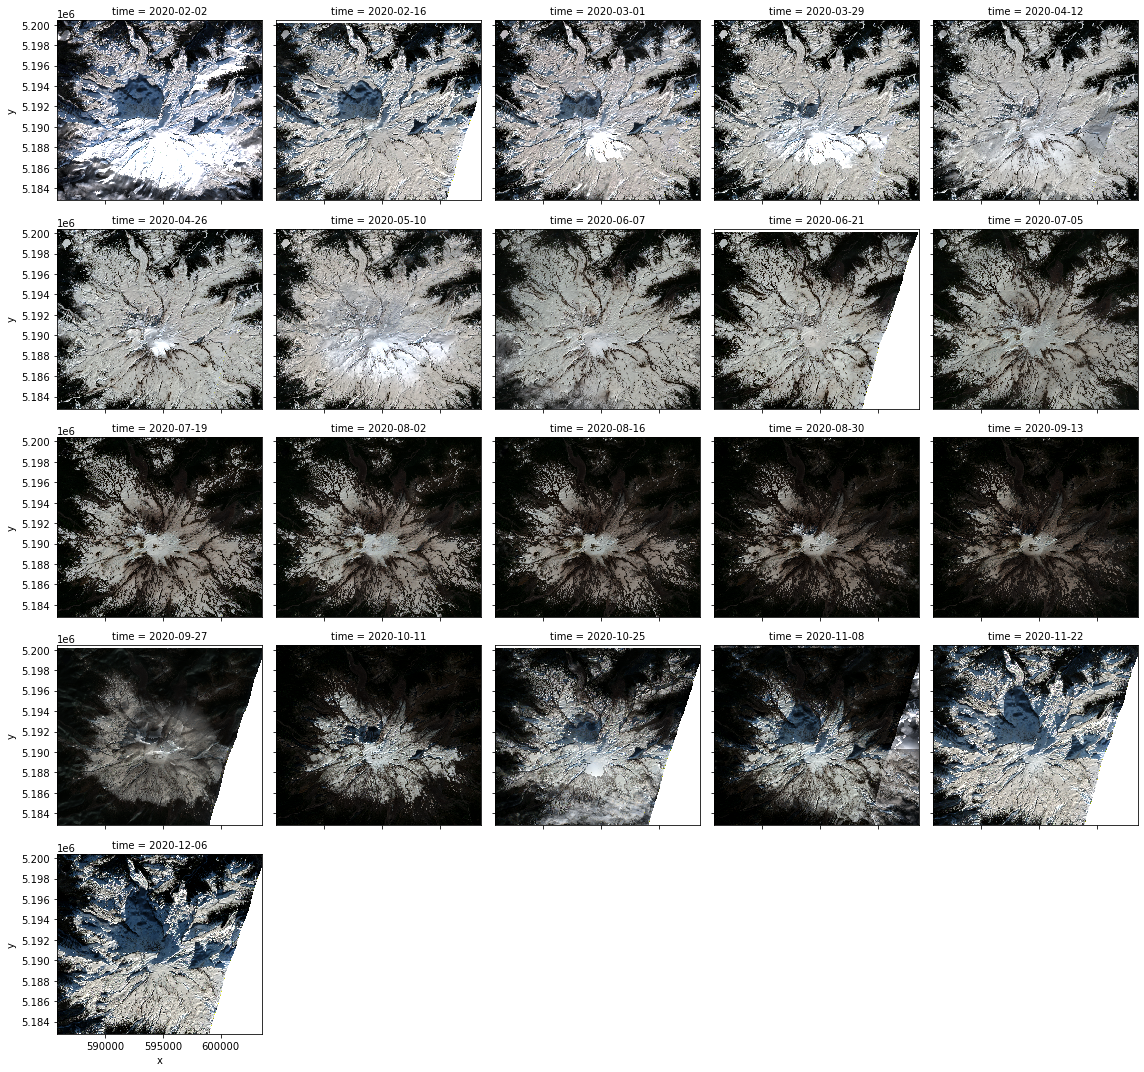

In [17]:
frames_rgb.plot.imshow(col="time", col_wrap = 5, rgb='band', robust=True,aspect=1);

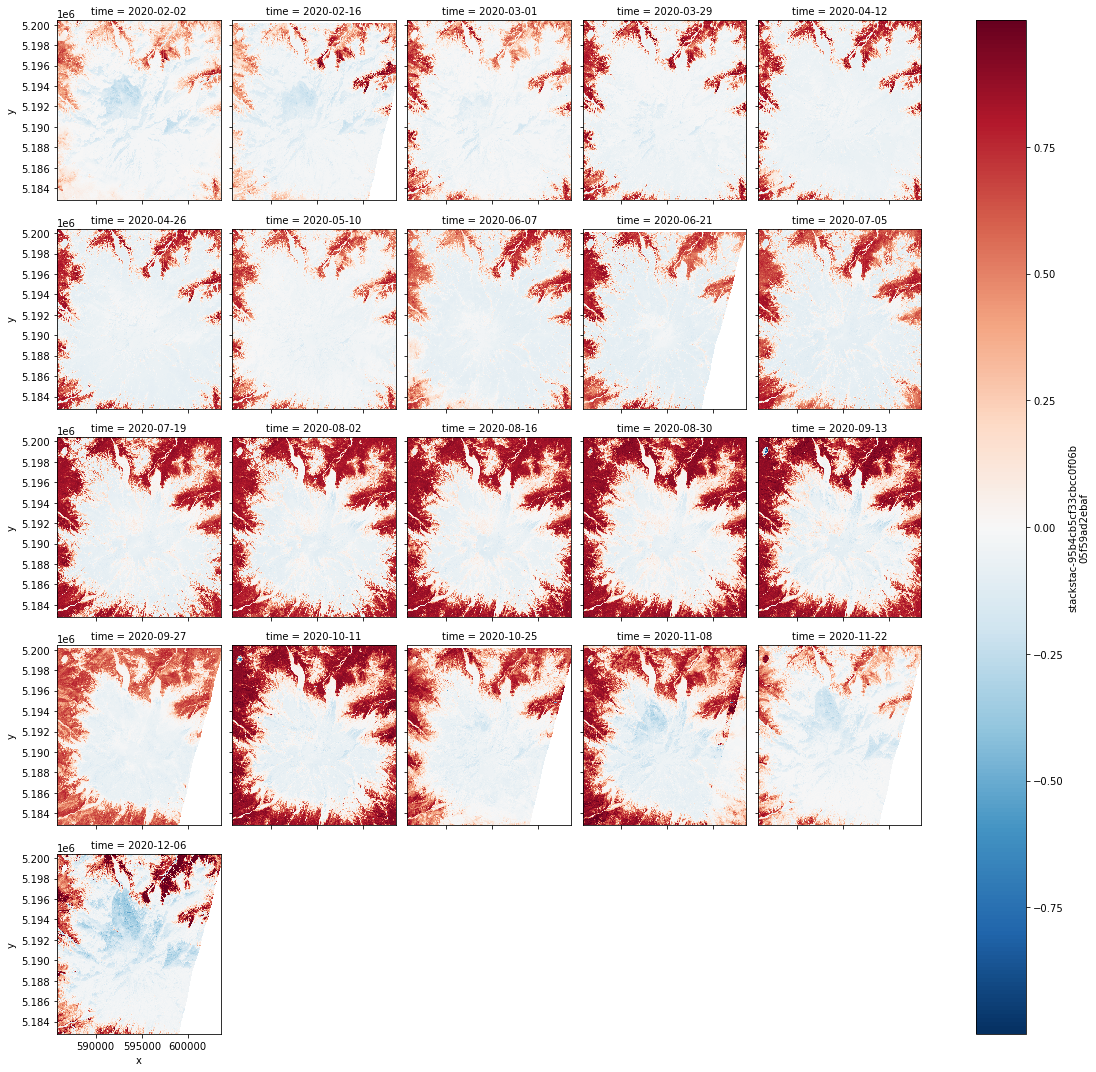

In [18]:
frames_ndvi.plot.imshow(col="time", col_wrap = 5, robust=False);

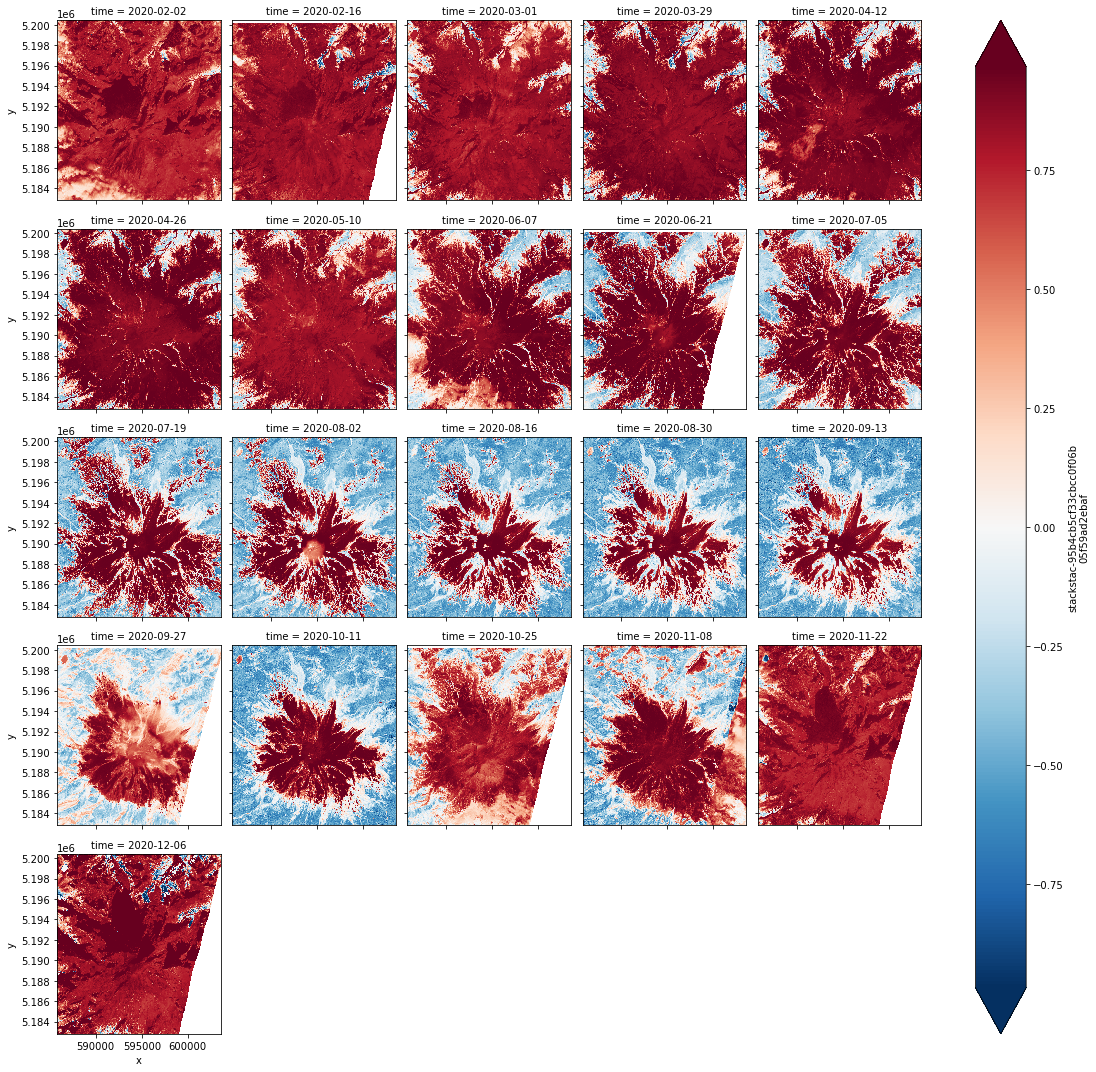

In [19]:
frames_ndsi.plot.imshow(col="time", col_wrap = 5, robust=True,aspect=1);

In [20]:
if shapefile_clip == True:
    rainier_glaciers = rainier_glaciers.to_crs(stack.crs)
    frames_nis = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Nisqually Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False)
    frames_emm = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Emmons Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_car = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Carbon Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_tah = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Tahoma Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_named = frames_ndsi.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)

Text(0.5, 1.0, 'Sentinel2 NDSI Values \nfor (2020-01-01, 2020-12-31)')

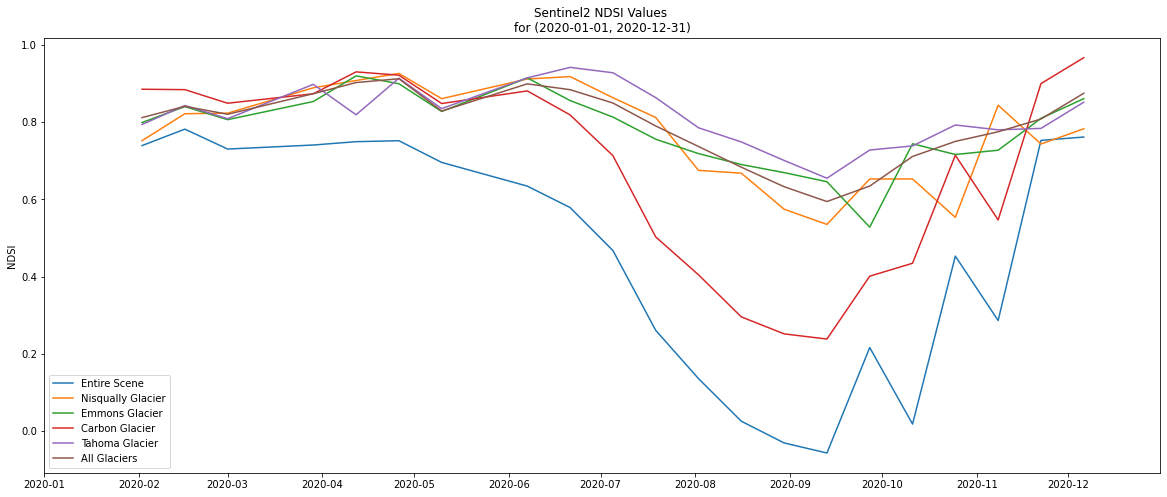

In [21]:
# look for local min for melt timings
f,ax = plt.subplots(figsize=(20,8))

ax.plot(frames_ndsi.time,frames_ndsi.mean(dim=['x','y']),label='Entire Scene')
ax.plot(frames_nis.time,frames_nis.mean(dim=['x','y']),label='Nisqually Glacier')
ax.plot(frames_emm.time,frames_emm.mean(dim=['x','y']),label='Emmons Glacier')
ax.plot(frames_car.time,frames_car.mean(dim=['x','y']),label='Carbon Glacier')
ax.plot(frames_tah.time,frames_tah.mean(dim=['x','y']),label='Tahoma Glacier')
ax.plot(frames_named.time,frames_named.mean(dim=['x','y']),label='All Glaciers')

#ax2=ax.twinx()
#snotel_df.plot.scatter(x='date_time_utc',y='value',ax=ax2,c='r',alpha=0.4,label='SWE')

ax.set_xlim([time_slice.start,time_slice.stop])
ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
ax.set_ylabel('NDSI')

ax.set_title(f'Sentinel2 NDSI Values \nfor ({time_slice.start}, {time_slice.stop})')

In [22]:
#%%time
#vis = lowcloud.sel(band='visual')
#vis = vis.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
#vis.compute()
#vis.plot.imshow(col="time", col_wrap = 5, robust=True);

In [23]:
# train all S2 bands on SAR backscatter data? 
# rate at which NDSI dips proportional to debris?

In [24]:
#frames_rgb = None
#frames_ndvi = None
#frames_ndsi = None

#frames_nis = None
#frames_emm = None
#frames_car = None
#frames_tah = None
#frames_named = None

In [25]:
#frames_rgb = None

In [26]:
#%%time
#scenes_all_bands = lowcloud.sel(band=['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12']).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
#frames_all_bands = scenes_all_bands.compute()

In [27]:
#f,ax = plt.subplots(figsize=(20,8))
#frames_all_bands = frames_all_bands.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)
#ax.plot(frames_all_bands.time,frames_all_bands.mean(dim=['x','y']),label='Entire Scene')

#ax.set_xlim([time_slice.start,time_slice.stop])
#ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
#ax.set_ylabel('Reflectance')

#ax.set_title(f'Sentinel2 All Band \nfor ({time_slice.start}, {time_slice.stop})')

In [28]:
frames_rgb

<xarray.DataArray 'stackstac-95b4cb5cf33cbcc0f06b05f59ad2ebaf' (time: 21, band: 3, y: 1762, x: 1778)>
array([[[[4.5900e+02, 5.7400e+02, 5.6000e+02, ..., 9.7100e+02,
          2.0460e+03, 2.9080e+03],
         [4.3100e+02, 5.3100e+02, 4.9800e+02, ..., 9.9200e+02,
          9.9500e+02, 1.8580e+03],
         [4.4900e+02, 4.6700e+02, 4.2500e+02, ..., 1.3620e+03,
          1.4180e+03, 1.7640e+03],
         ...,
         [6.5320e+03, 6.3920e+03, 6.1680e+03, ..., 7.3800e+02,
          7.0500e+02, 7.3400e+02],
         [6.2160e+03, 6.0880e+03, 5.8600e+03, ..., 7.9200e+02,
          7.1400e+02, 7.1100e+02],
         [5.8320e+03, 5.6720e+03, 5.4360e+03, ..., 8.1200e+02,
          7.2600e+02, 6.9600e+02]],

        [[4.0300e+02, 4.9000e+02, 5.1200e+02, ..., 9.2200e+02,
          1.9060e+03, 3.0420e+03],
         [3.9700e+02, 4.5600e+02, 4.2100e+02, ..., 9.7100e+02,
          1.0280e+03, 1.9920e+03],
         [4.2100e+02, 4.0600e+02, 3.5400e+02, ..., 1.2860e+03,
          1.4160e+03, 1.6220e+03],
...
         [4.4100e+02, 3.0200e+02, 7.1000e+02, ...,        nan,
                 nan,        nan],
         [3.3600e+02, 6.9700e+02, 1.0190e+03, ...,        nan,
                 nan,        nan],
         [5.2100e+02, 7.1700e+02, 7.8900e+02, ...,        nan,
                 nan,        nan]],

        [[9.4000e+01, 5.2000e+01, 4.8000e+01, ..., 6.1700e+02,
          1.9480e+03, 2.3740e+03],
         [4.4000e+01, 7.8000e+01, 7.1000e+01, ..., 2.1700e+02,
          5.7900e+02, 1.0500e+03],
         [5.4000e+01, 1.2600e+02, 9.5000e+01, ..., 2.7100e+02,
          2.7700e+02, 3.8900e+02],
         ...,
         [2.6900e+02, 3.0200e+02, 6.2100e+02, ...,        nan,
                 nan,        nan],
         [2.6200e+02, 5.9100e+02, 8.9300e+02, ...,        nan,
                 nan,        nan],
         [3.3900e+02, 1.0170e+03, 6.6400e+02, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * time                    (time) datetime64[ns] 2020-02-02 ... 2020-12-06
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 5.858e+05 5.858e+05 ... 6.036e+05
  * y                       (y) float64 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
    instruments             <U3 'msi'
    constellation           <U10 'sentinel-2'
    view:off_nadir          int64 0
    gsd                     (band) object 10 10 10
    proj:epsg               int64 32610
    sentinel:latitude_band  <U1 'T'
    sentinel:utm_zone       int64 10
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(499980.0, 5090220.0, 609780.0...
    crs:         epsg:32610
    transform:   | 10.00, 0.00, 499980.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0